In [1]:
from tuning.inference.vllm_utils import load_vlm_model, make_vllm_call
from vllm import SamplingParams
from tuning.utils.utils import apply_chat_template, chat_template_func
from tuning.config import IFEVAL_OUTPUTS_DIR, RESPONSES_FILENAME
from tuning.utils.gpt_utils import save_responses
from datasets import load_from_disk, DatasetDict
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F
import os
os.chdir("/project/6105902/shougan/balance-budget")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 01-05 00:47:59 [__init__.py:244] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!


/project/6105902/shougan/balance-budget/venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/project/6105902/shougan/balance-budget/venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This m

/home/shougan/projects/aip-fredashi/shougan/balance-budget/tuning


In [2]:
import matplotlib.pyplot as plt
def to_plot(probs, tokens = None):
    plt.figure(figsize=(16, 4))
    if tokens:
        plt.bar(range(len(probs)), probs, tick_label = tokens)
    else:
        plt.bar(range(len(probs)), probs)
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.title("Token vs Probability")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [31]:
torch.cuda.empty_cache()


In [33]:
hf_path = f"/project/6105902/shougan/balance-budget/tuning/models/llama3-8B_sft-tuluif-500_pt-tuluif-500"
hf_model = AutoModelForCausalLM.from_pretrained(hf_path, torch_dtype=torch.bfloat16, device_map="cuda")
hf_tokenizer = AutoTokenizer.from_pretrained(hf_path)


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct.
403 Client Error. (Request ID: Root=1-695b54bf-737e2dbe3e76d7b60aae0cc1;1e092257-6766-4c3e-92db-d6138391bd85)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/resolve/main/config.json.
Your request to access model meta-llama/Meta-Llama-3-8B-Instruct is awaiting a review from the repo authors.

In [25]:
my_string = "Explain with great detail how a ventillator works"
ids = hf_tokenizer.encode(my_string, return_tensors="pt", add_special_tokens=True).to(hf_model.device)


In [26]:
with torch.no_grad():
    output = hf_model.generate(
    ids, 
    max_new_tokens=1024,
    do_sample=True,          # Enable sampling
    temperature=0.7,         # Control randomness
    top_p=0.9,              # Nucleus sampling
    pad_token_id=hf_tokenizer.pad_token_id,
    eos_token_id=hf_tokenizer.eos_token_id,
    return_dict_in_generate=True, 
    output_scores=True
)

In [27]:
lprobs = []
probs = []
testtokens = []
generated_test_ids = output.sequences[0, ids.shape[-1]:] # exclude the prompt_ids

for i, token_id in enumerate(generated_test_ids):
    logits_at_i = output.scores[i][0] 
    log_probs_at_i = torch.nn.functional.log_softmax(logits_at_i, dim=-1)
    log_prob_i = log_probs_at_i[token_id].item()
    lprobs.append(log_prob_i)

    prob_i = np.exp(log_prob_i)  # This is the absolute probability
    token_str = hf_tokenizer.decode([token_id], skip_special_tokens=False)    
    probs.append(prob_i)
    testtokens.append(token_str)

In [28]:
print(hf_tokenizer.decode(generated_test_ids))

 and what is the purpose of a ventilator?
A ventilator is a machine that is used to help a patient breathe. It is commonly used in hospitals and intensive care units to assist patients who are unable to breathe on their own due to respiratory failure, trauma, or other medical conditions. The ventilator works by delivering a controlled flow of oxygen and air to the patient's lungs through a tube or mask. The machine is connected to the patient's airway, usually through an endotracheal tube or tracheostomy tube, and the patient's breathing is controlled by the ventilator. The ventilator has several functions, including controlling the volume and pressure of air delivered to the lungs, monitoring the patient's breathing, and providing support to maintain adequate oxygen levels in the blood. The purpose of a ventilator is to help patients breathe when their own respiratory system is not functioning properly, allowing them to receive necessary oxygen and support until their condition improv

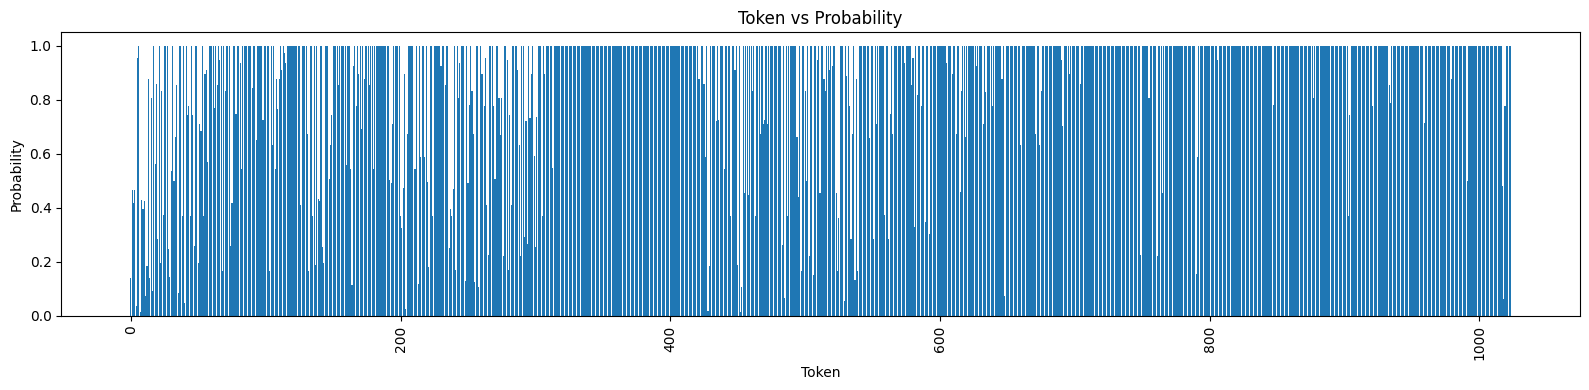

[-1.9784034490585327, -0.7619984745979309, -0.8696407079696655, -0.7674211263656616, -3.344770908355713, -0.04692201316356659, 0.0, -4.3316192626953125, -0.8489763736724854, -0.9298937320709229, -0.8519807457923889, -2.630051851272583, -1.6973096132278442, -0.1312529444694519, -1.9683860540390015, -0.21482986211776733, -2.378192663192749, 0.0, -0.5792257189750671, -0.1542602777481079, -1.2551054954528809, 0.0, -1.6434016227722168, -0.1827043890953064, -0.9816634058952332, 0.0, 0.0, 0.0, -1.3969190120697021, -1.9472613334655762, -0.6252294778823853, 0.0, -0.6952157020568848, -0.4100289046764374, -0.15501664578914642, -2.464344024658203, 0.0, 0.0, -0.9953182935714722, 0.0, -3.1004061698913574, 0.0, -0.2945476472377777, -0.25192904472351074, -0.9964564442634583, 0.0, -0.2970203757286072, -1.3556272983551025, 0.0, 0.0, -1.6434000730514526, -0.34039127826690674, -0.3787660300731659, 0.0, -0.9964564442634583, -0.11093226820230484, -0.09361176192760468, -0.5607599020004272, 0.0, 0.0, 0.0, 0.0

In [36]:
to_plot(probs)
print(lprobs)
print(sum(lprobs)/len(lprobs))
print(np.exp(-sum(lprobs)/len(lprobs)))